# <center> Notebook : Multiscale Volatility Model Asymptotics </center>

Grégoire GALLOT et Adrien MEILAC


Ce notebook est joint en complemment du rapport sur l'article de Fouque (et co-auteurs) _"Multiscale Volatility Model Asymptotics"_. Nous commencerons par définir les différents packages utilisés par la suite. Ensuite, nous simulerons le modèle en spécifiant les paramètres que l'on a détaillé dans le rapport. Cela nous mènera à étudier les sensibilités des paramètres. Enfin, nous parlerons du problème lié à la calibration à partir des données de marché. 



# Sommaire
* 1 - Import des données et sauvegarde locale
    * 1.1 - Récupération des données des options sur SP500 
    * 1.2 - Création, renommage et sélection des variables
* 2 - Simulation et sensibilité du modèle 
    * 2.1 - Simulations du modèle
    * 2.2 - Graphe de la trajectoire selon les coordonnées du brownien 
    * 2.3 - Simulation du modèle 
    * 2.4 - Simulations du modèle
* 3 - Calibration et pricing à partir des données de marché 
    * 3.1 - Calibration du modèle 
    * 3.2 - Volatilité implicite empirique en fonction du log moneyness et du Log-Moneyness To Maturity Ratio
    * 3.3 - Calcul des grecques
    * 3.4 - Calcul des prix

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import datetime as dt
import numpy as np 
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score
from scipy.interpolate import griddata
from scipy.stats import norm
import yfinance as yf

# 1 - Préprocessing des données
Dans cette section, nous allons juste importer nos données et préparer les librairies qui nous seront utiles par la suite. 

Nous utilisons cependant la librairie yfinance afin de récupérer les données des quotations des options sur le SP500. Il faut donc la télécharger préalablemment (nous pouvons utiliser la commande : "pip install yfinance") 


## 1.1 - Récupération des données des options sur SP500 

In [3]:
# Récupération des données des options sur SP500 
GSPC = yf.Ticker("^GSPC")

# Concaténation de tous les calls de toutes les maturités disponibles, dans un seul tableau
L = []
for exp in GSPC.options:
    temp = GSPC.option_chain(exp).calls
    temp["T"] = exp
    L.append(temp)

df = pd.concat(L)
del L
del temp

In [4]:
print("Les maturités disponibles pour nos calls sont : {}".format(", ".join(GSPC.options)))

Les maturités disponibles pour nos calls sont : 2020-06-19, 2020-12-18, 2021-12-17


## 1.2 - Création, renommage et sélection des variables

In [5]:
#Today : date d'aujourd'hui pour le calcul du prix
df["Today"] = dt.datetime.now()

# Tau = Time to Maturity en jours 
df["tau"] = (pd.to_datetime(df["T"]) - df["Today"]).astype("timedelta64[D]") / 365
  
# On récupère ici la valeur de l'indice pour la date d'aujourd'hui 
df["S0"] = GSPC.history(period = "max")["Close"].tail(1).values[0] 
# df = pd.merge(df, temp, how = "left", left_on = "Today", right_index = True)

In [6]:
# Renommage et sélection des des variables
df = df.rename({"strike": "K", "impliedVolatility" : "I_bs"}, axis = 1)
df = df[["K", "I_bs", "tau", "S0"]]

In [7]:
df

,K,I_bs,tau,S0
0,1100.0,1.819169,0.169863,2799.55
1,1500.0,1.307422,0.169863,2799.55
2,1600.0,1.203083,0.169863,2799.55
3,1700.0,1.106267,0.169863,2799.55
4,1725.0,1.083119,0.169863,2799.55
...,...,...,...,...
35,3300.0,0.216679,1.665753,2799.55
36,3400.0,0.207938,1.665753,2799.55
37,3500.0,0.199734,1.665753,2799.55
38,3600.0,0.192528,1.665753,2799.55


# 2 - Simulation et sensibilité du modèle 

Pour cette partie, nous allons seulement faire une simulation du modèle selon des valeurs que l'on mettra en paramètre. Nous allons nous baser sur l'équation suivante : 
\begin{equation}
                \left\{
                    \begin{array}{ll}
                        dX_t / X_t = rdt + f(Y_t, Z_t)dW_t^{(0)*} \\
                        dY_t = (\varepsilon^{-1}(m-Y_t) - \nu \sqrt{2/\varepsilon} \Lambda(Y_t, Z_t) ) dt + \nu \sqrt{2/ \varepsilon} dW_t^{(1)*} \\
                        dZ_t = (\delta c(Z_t) - \sqrt{\delta} g(Z_t) \Gamma(Y_t, Z_t)) dt + \sqrt{\delta} g(Z_t) dW_t^{(2)*}
                    \end{array}
                \right. 
            \end{equation}
            
Pour des soucis de simplifications, on va supposer $\Lambda$ et $\Gamma$ égales à 0.

## 2.1 - Spécifications des corrélations

In [8]:
rho_1 = -0.02
rho_2 = -0.2
rho_12 = 0

T = 3 # Date de fin
N = 10000 # Nombre d'étapes 

mean = [0, 0, 0]
cov = [[1, rho_1, rho_2],
       [rho_1, 1, rho_1 * rho_2 + rho_12 * np.sqrt(1- rho_1**2)],
       [rho_2, rho_1 * rho_2 + rho_12 * np.sqrt(1- rho_1**2), 1]]

In [9]:
# Simulations du mouvement brownien à 3 dimensions avec correlation (par la méthode de la matrice de choleski)

Chol = np.linalg.cholesky(cov)
# On retrouve bien la matrice
# [1 0 0]
# [rho_1, sqrt(1 - rho_1 ** 2), 0]
# [rho_2, rho_12, sqrt(1 - rho_2 ** 2 - rho_12**2)]
dt = np.arange(T, step = T / N)

W = np.zeros((N,3))
#Norm = np.zeros((N,3))
Wcor = np.zeros((N,3))
for i in range(1, N):
    #Norm[i] = np.random.normal(0,1,3)
    W[i]= W[i - 1] + np.sqrt(T / N) * np.random.normal(0, 1, 3)
    Wcor[i] = np.dot(W[i], Chol)
W = Wcor

In [10]:
Chol

array([[ 1.        ,  0.        ,  0.        ],
       [-0.02      ,  0.99979998,  0.        ],
       [-0.2       ,  0.        ,  0.9797959 ]])

## 2.2 - Graphe de la trajectoire selon les coordonnées du brownien 

<IPython.core.display.Javascript object>


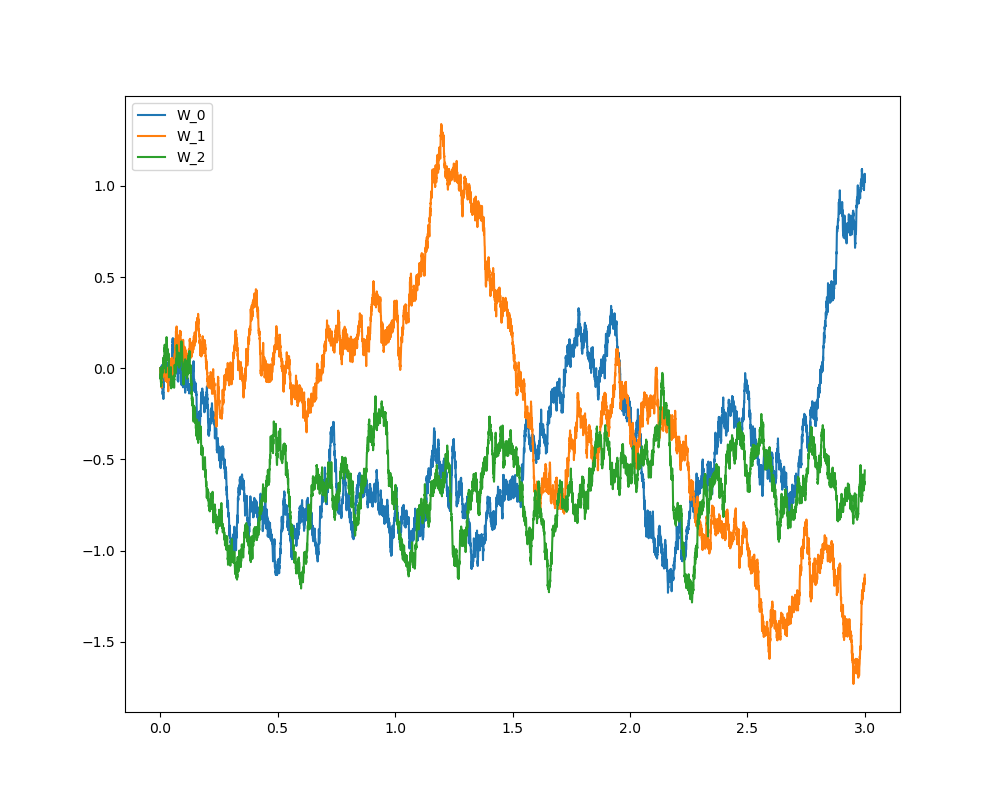

In [11]:
plt.figure(figsize = (10, 8))
for i in range(3):
    s = 'W_'+ str(i) 
    plt.plot(dt, Wcor.T[i], label = s)
    plt.legend()

## 2.3 - Simulation du modèle 

In [12]:
X0 = 55
Y0 = -1
Z0 = -1
r = 0.1
mu = 0.2
nu = 0.5
eps = 0.1
m = -0.8
delta = 0.01
m_z = -0.8
nu_z = 0.8
f = lambda x, y: np.exp(x + y)
c = lambda x: m_z - x
g = lambda x: nu_z * np.sqrt(2)

In [13]:
def S(M, i):
    [X, Y, Z] = M
    dt = T / N
    [dW0, dW1, dW2] = W[i+1] - W[i]
    dX = r * X * dt + f(Y, Z)* X * dW0
    dY = (m - Y) / eps * dt + nu * np.sqrt(2 / eps) * dW1
    dZ = delta * c(Z) * dt + np.sqrt(delta) * g(Z) * dW2
    return [X + dX, Y + dY, Z + dZ]

M = np.zeros((N, 3))
M[0] = np.array([X0, Y0, Z0])
for i in range(0, N - 1):
    M[i + 1] = S(M[i], i)
    

<IPython.core.display.Javascript object>


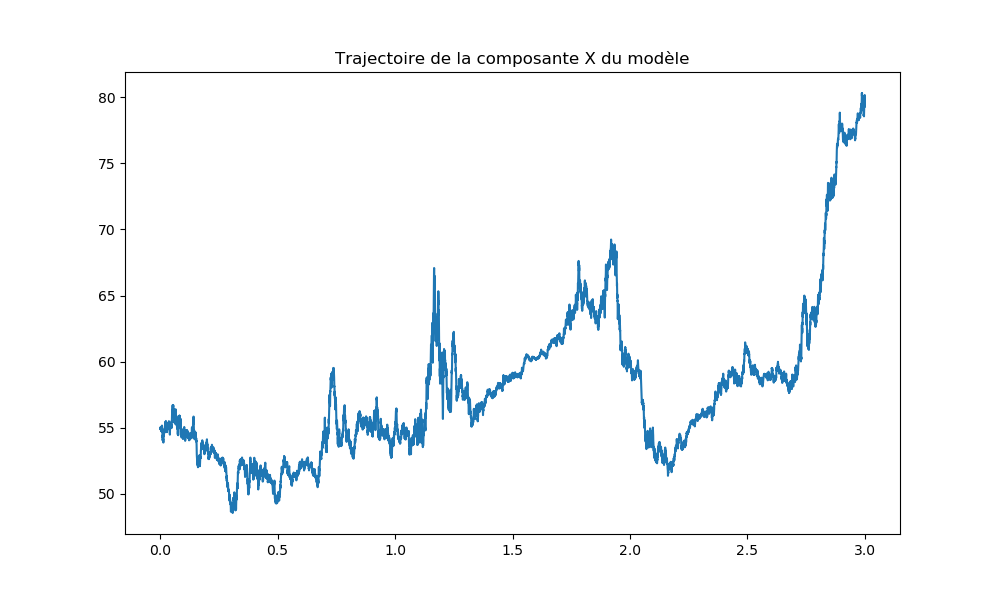

<IPython.core.display.Javascript object>


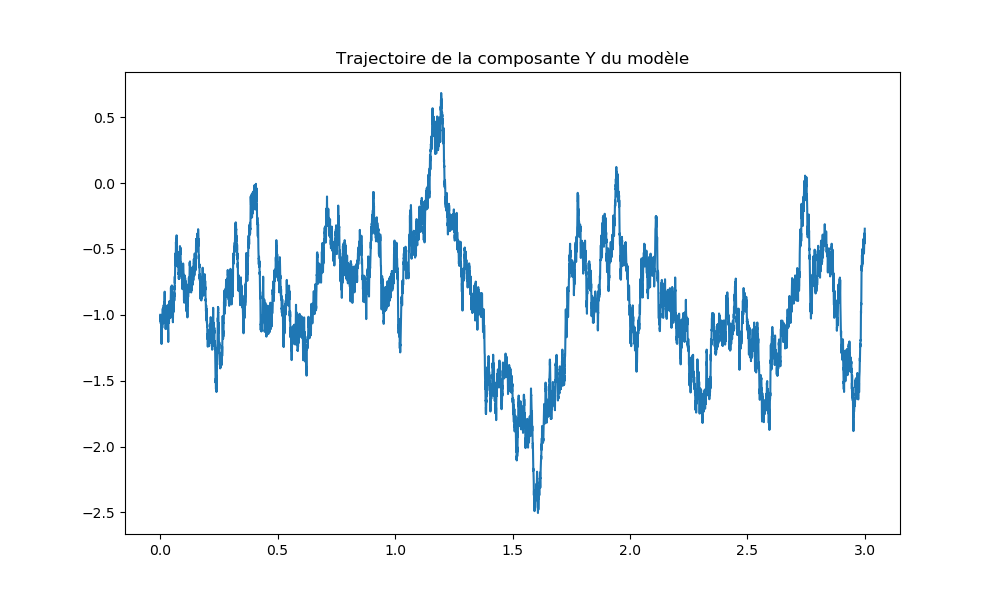

<IPython.core.display.Javascript object>


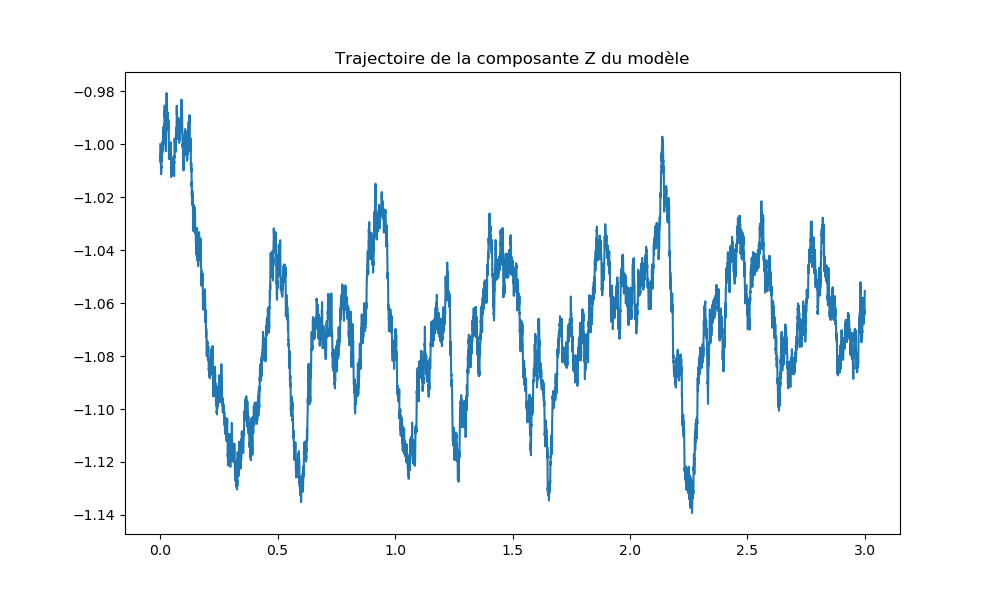

In [14]:
for i, v in enumerate(["X", "Y", "Z"]):
    plt.figure(figsize = (10, 6))#(figsize = (15, 8))
    plt.plot(dt, M.T[i])
    plt.title("Trajectoire de la composante {} du modèle".format(v))

Outre cette simulation numérique du modèle, nous pouvons également calculer le prix de marché grâce aux formules fermées présentées dans le rapport. 

# 3 - Calibration et pricing à partir des données de marché 

Comme expliqué dans la partie 3. du rapport, pour obtenir les prix de marché d'une options nous devons connaître $a^\varepsilon, b^\varepsilon, a^\delta, b^\delta$
Nous devons également calculer $\bar{\sigma}$, la volatilité effective, celle-ci sera estimée comme l'historique récent de la volatilité (5/7 jours).

Nous allons commencer par estimer la valeur du taux d'intérêt sans risque. Comme nous allons étudier le Sp500, nous avons décidé de fixer ce taux à celui d'un taux interbancaire américain (FED). Au vu des conditions actuelles des marchés, nous préfèrons prendre une date d'étude assez lointaine pour ne pas subir l'effet de ces données stressées. 


## 3.1 - Calibration du modèle 

In [15]:
#Taux sans risque
r = 0.0125 #Taux FED 

# Calcul de la volatilité effective (estimateur historique)
S = GSPC.history(period = "5d")
msigma = np.std(np.log(S["Open"].shift() / S["Open"]))
print("La valeur de sigma moyenne est {0:.3f}".format(msigma))

La valeur de sigma moyenne est 0.004


Grâce à l'approximation de la volatilité implicite du modèle, nous pouvons calibrer le modèle afin de trouver des valeurs pour nos coefficients $a$ et $b$. pour cela, nous avons opter pour une régression linéaire à partir de l'expression suivante :

$$
    I \approx \bar{\sigma} + b^\varepsilon + a^\varepsilon LMMR + a^\delta LM + b^\delta \tau
$$

In [16]:
# Calcul du log-moneyness
df["LM"] =  np.log(df["K"] / df["S0"])

# Calcul du Log-Moneyness To Maturity Ratio
df["LMMR"] = df["LM"] / df["tau"]

reg = LinearRegression().fit(df[["LMMR", "LM", "tau"]], df["I_bs"])

[a_eps, a_delta, b_delta] = reg.coef_
b_eps = reg.intercept_ - msigma 

print("a_eps \t\t= {0:.3f}".format(a_eps))
print("b_eps \t\t= {0:.3f}".format(b_eps))
print("b_delta \t= {0:.3f}".format(b_delta))
print("a_delta \t= {0:.3f}".format(a_delta))

a_eps 		= -0.167
b_eps 		= 0.461
b_delta 	= -0.147
a_delta 	= -0.193


A présent, nous allons calculer nos paramètres : $V_0^\delta, V_1^\delta, V_2^\varepsilon, V_3^\varepsilon$ 

In [17]:
# Calcul des paramètres de marché
V_0_delta = - msigma * (b_delta + a_delta * (r - msigma ** 2 / 2))
V_1_delta = - a_delta * msigma ** 3
V_2_eps = - msigma * (b_eps + a_eps *  (r - msigma ** 2 / 2))
V_3_eps = - a_eps * msigma ** 3

def implied_volatility(row):
    tau = row["tau"]
    x = row["S0"]
    K = row["K"]
    V_3_eps = - a_eps * msigma ** 3
    # equation 4.8
    d1 = (np.log(x / K) + (r + msigma ** 2 / 2) * tau) / (msigma * np.sqrt(tau))
    # equation 4.10
    I_1_eps = - (V_2_eps + V_3_eps * (1 - d1 / (msigma * np.sqrt(tau)))) / msigma
    I_1_delta = - tau * (V_0_delta + V_1_delta * (1 - d1 / (msigma * np.sqrt(tau)))) / msigma
    # equation 4.5
    I_0 = msigma
    # equation 4.2
    I = I_0 + I_1_eps + I_1_delta
    return I

df["I_emp"] = df.apply(implied_volatility, axis = 1)

## 3.2 - Volatilité implicite empirique en fonction du log moneyness et du Log-Moneyness To Maturity Ratio

<IPython.core.display.Javascript object>


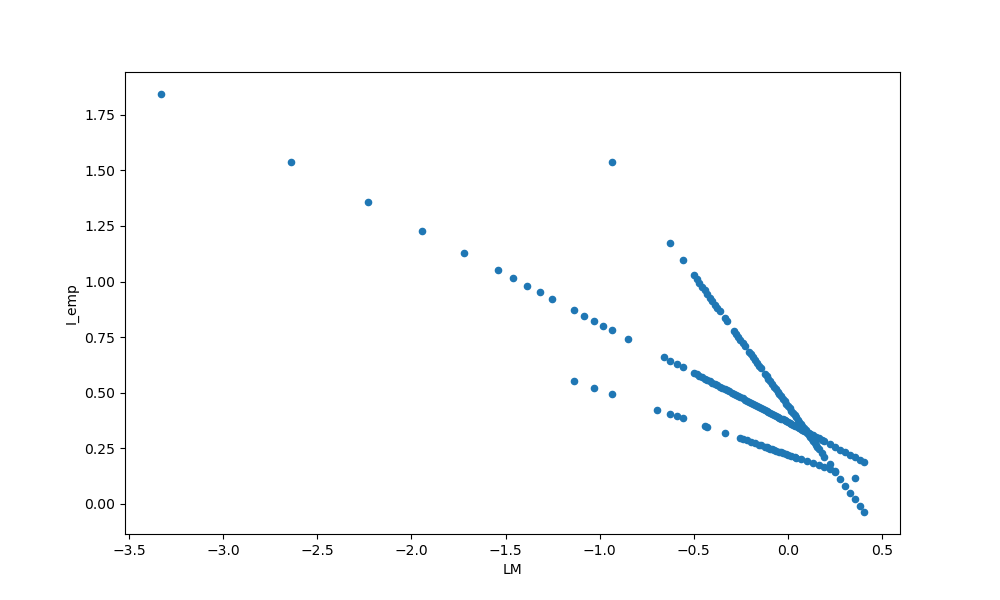

In [18]:
df.plot.scatter(x = "LM", y = "I_emp", figsize = (10, 6))

<IPython.core.display.Javascript object>


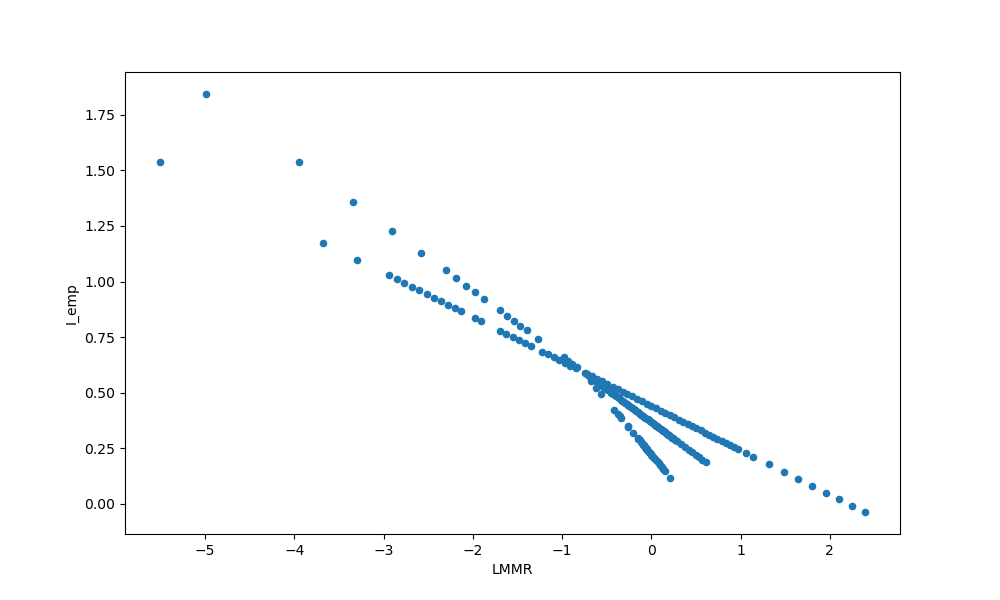

In [19]:
df.plot.scatter(x = "LMMR", y = "I_emp", figsize= (10, 6))

<IPython.core.display.Javascript object>


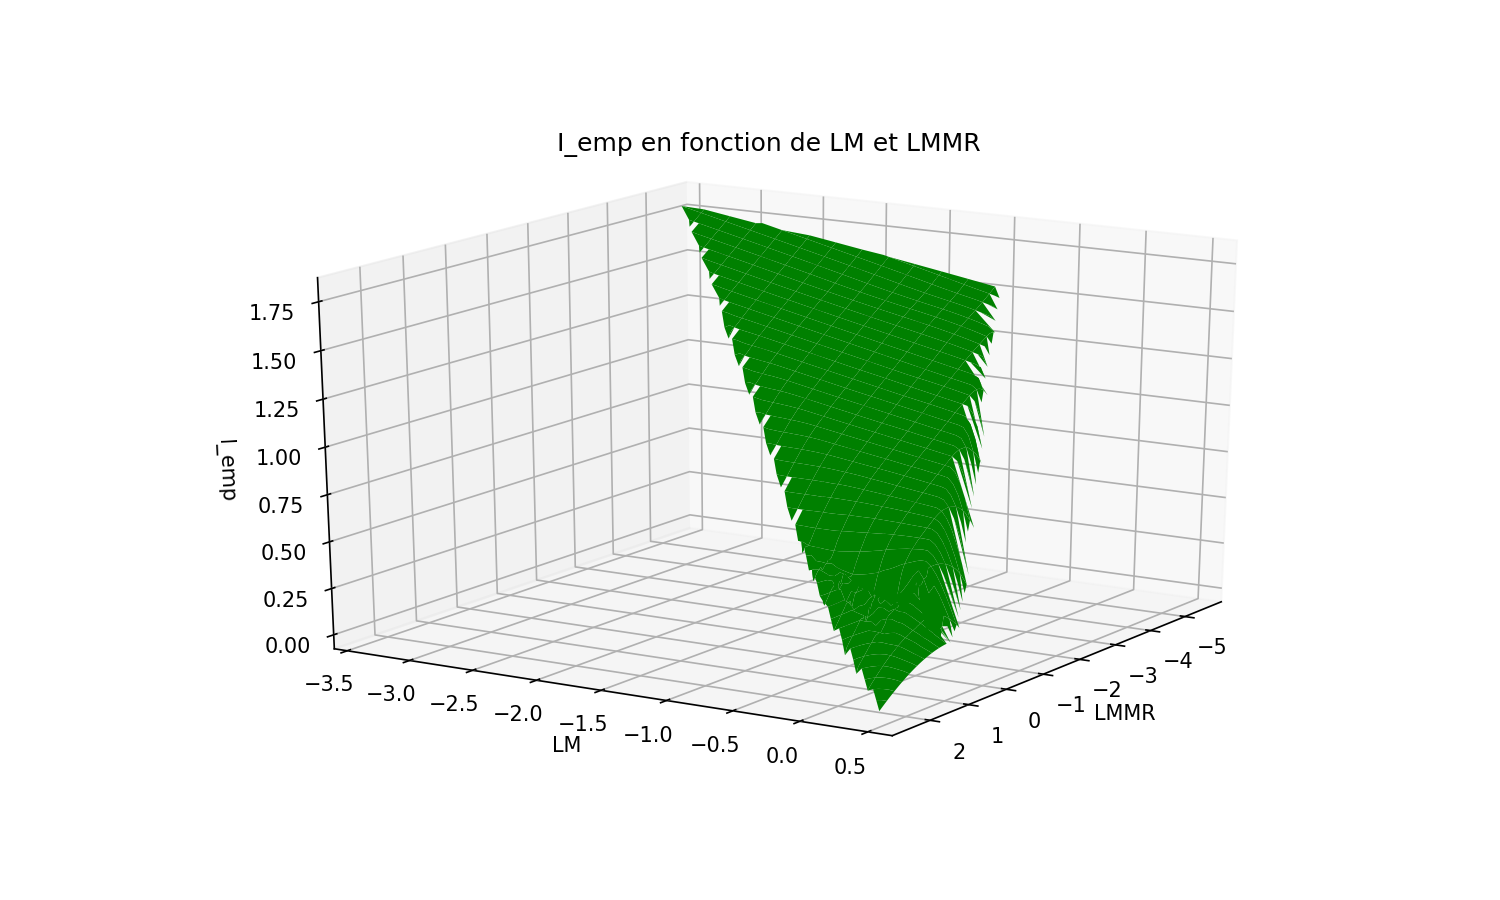

c:\add\x64\python\3.6\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [31]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
# 2D-arrays from DataFrame

x1 = np.linspace(df["LMMR"].min(), df["LMMR"].max(), len(df["LMMR"].unique()))
y1 = np.linspace(df["LM"].min(), df["LM"].max(), len(df["LM"].unique()))

"""
x, y via meshgrid for vectorized evaluation of
2 scalar/vector fields over 2-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.
"""

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((df["LMMR"], df["LM"]), df["I_emp"], (x2, y2), method='cubic')


# Ready to plot
fig = plt.figure(figsize= (10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, rstride=5, cstride=5, cmap=cm.ocean, linewidth=2)#,
                       #linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("LMMR")
ax.set_ylabel("LM")
ax.set_zlabel("I_emp")
ax.set_title("I_emp en fonction de LM et LMMR")
#ax.set_rotation(-30)
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


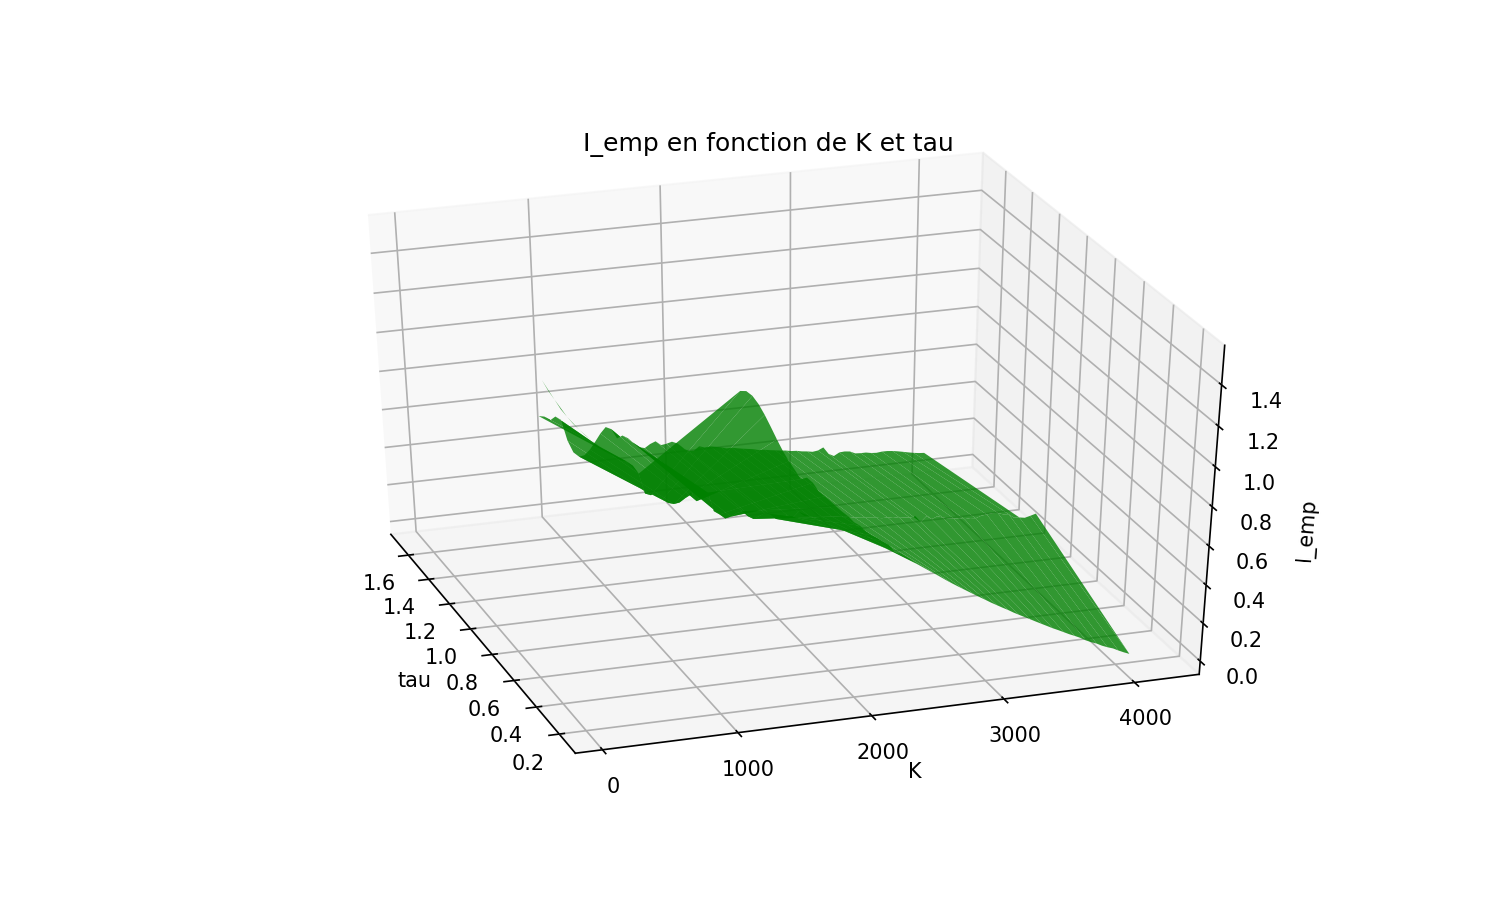

c:\add\x64\python\3.6\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [47]:
x1 = np.linspace(df["tau"].min(), df["tau"].max(), len(df["tau"].unique()))
y1 = np.linspace(df["K"].min(), df["K"].max(), len(df["K"].unique()))

"""
x, y via meshgrid for vectorized evaluation of
2 scalar/vector fields over 2-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.
"""

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((df["tau"], df["K"]), df["I_emp"], (x2, y2), method='cubic')


# Ready to plot
fig = plt.figure(figsize=(10,  6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, ccount = 100, cmap=cm.ocean, linewidth=5, alpha = 0.8)#,
                       #linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.invert_xaxis()
ax.set_xlabel("tau")
ax.set_ylabel("K")
ax.set_zlabel("I_emp")
ax.set_title("I_emp en fonction de K et tau")
#ax.set_rotation(-30)
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


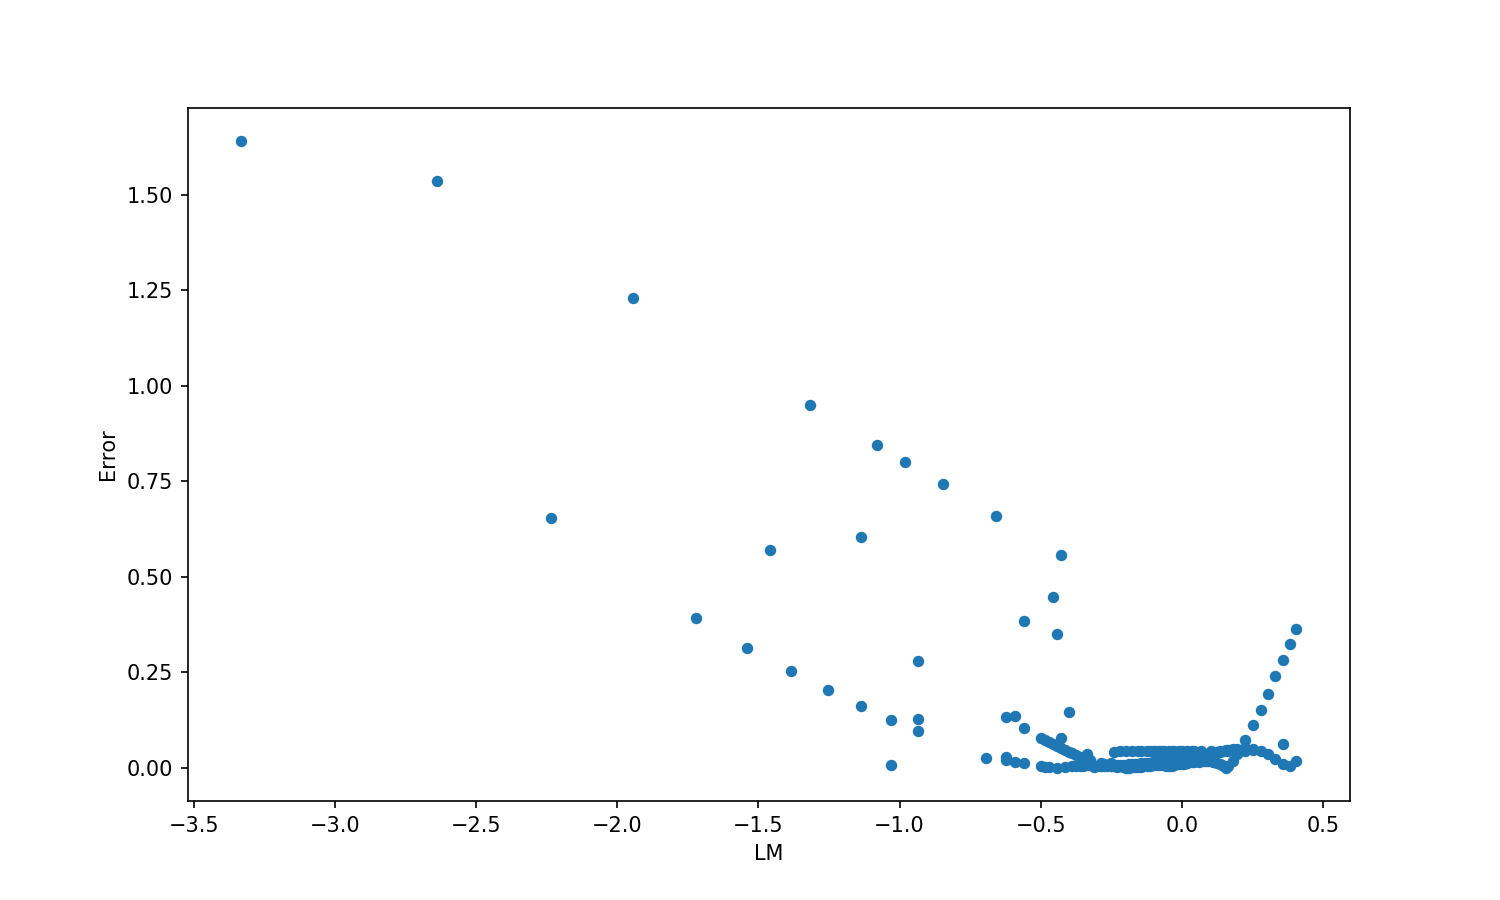

<IPython.core.display.Javascript object>


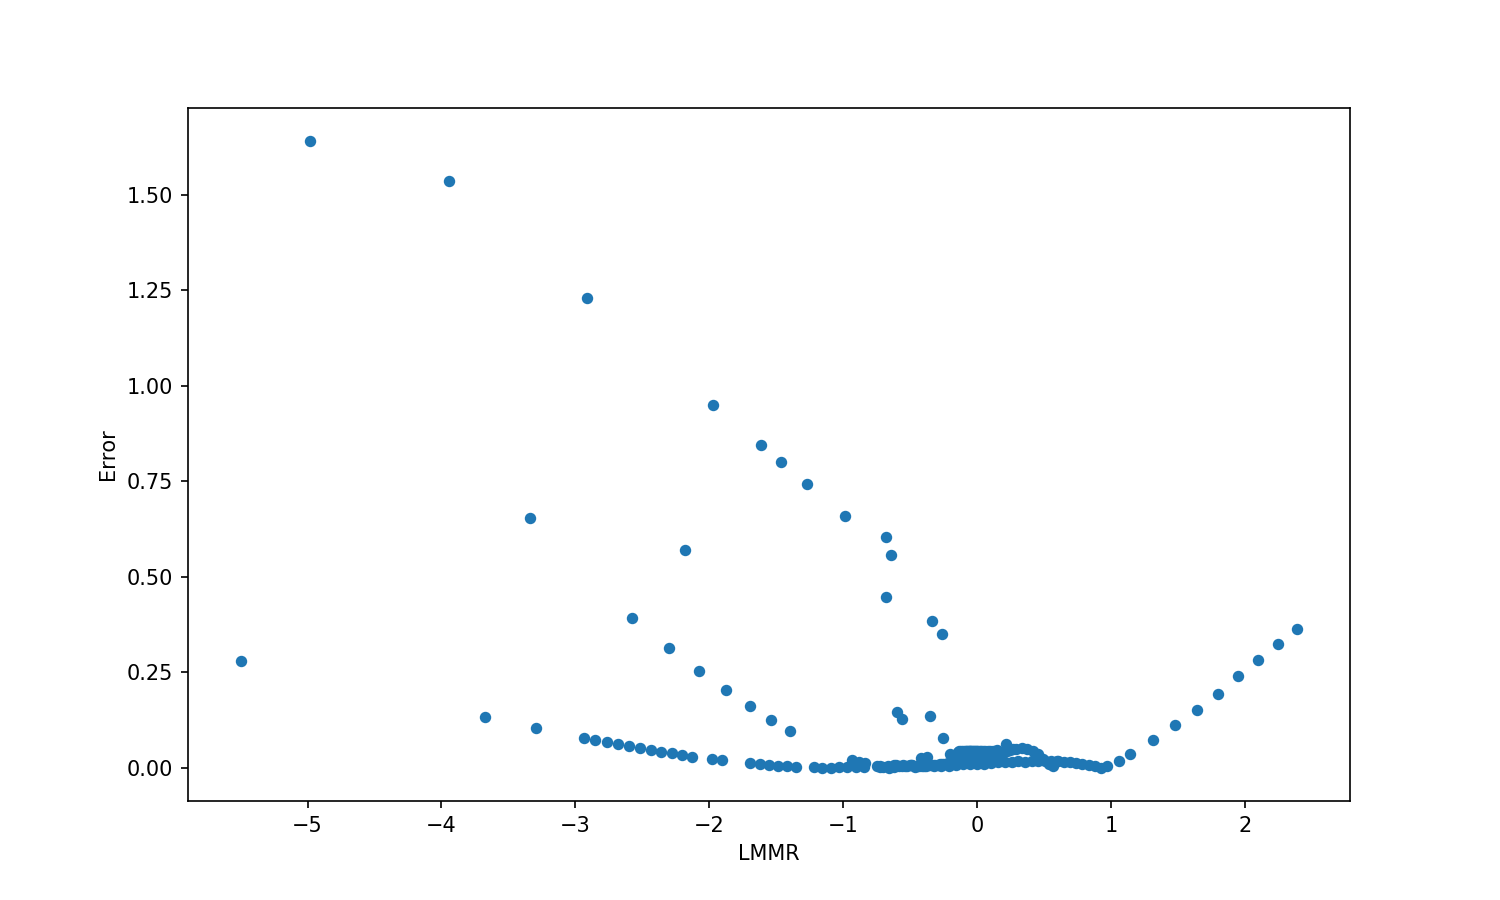

In [48]:
#Erreur d'approximation selon Lm et LMMR
df['Error'] = abs(df["I_emp"] - df["I_bs"])
df.plot.scatter(x = "LM", y = "Error", figsize =  (10, 6))
df.plot.scatter(x = "LMMR", y = "Error", figsize =  (10, 6))

Au vu des deux graphiques ci-dessus, nous pouvons observer une erreur très faible pour des LMMR $\in [-1,1]$ et des LM $\in [-0.5,0.5]$. Par conséquent, nous pouvons conclure que le modèle réplique assez bien les prix de marché pour des options en dehors d'extrêmes (ITM et OTM).

<IPython.core.display.Javascript object>


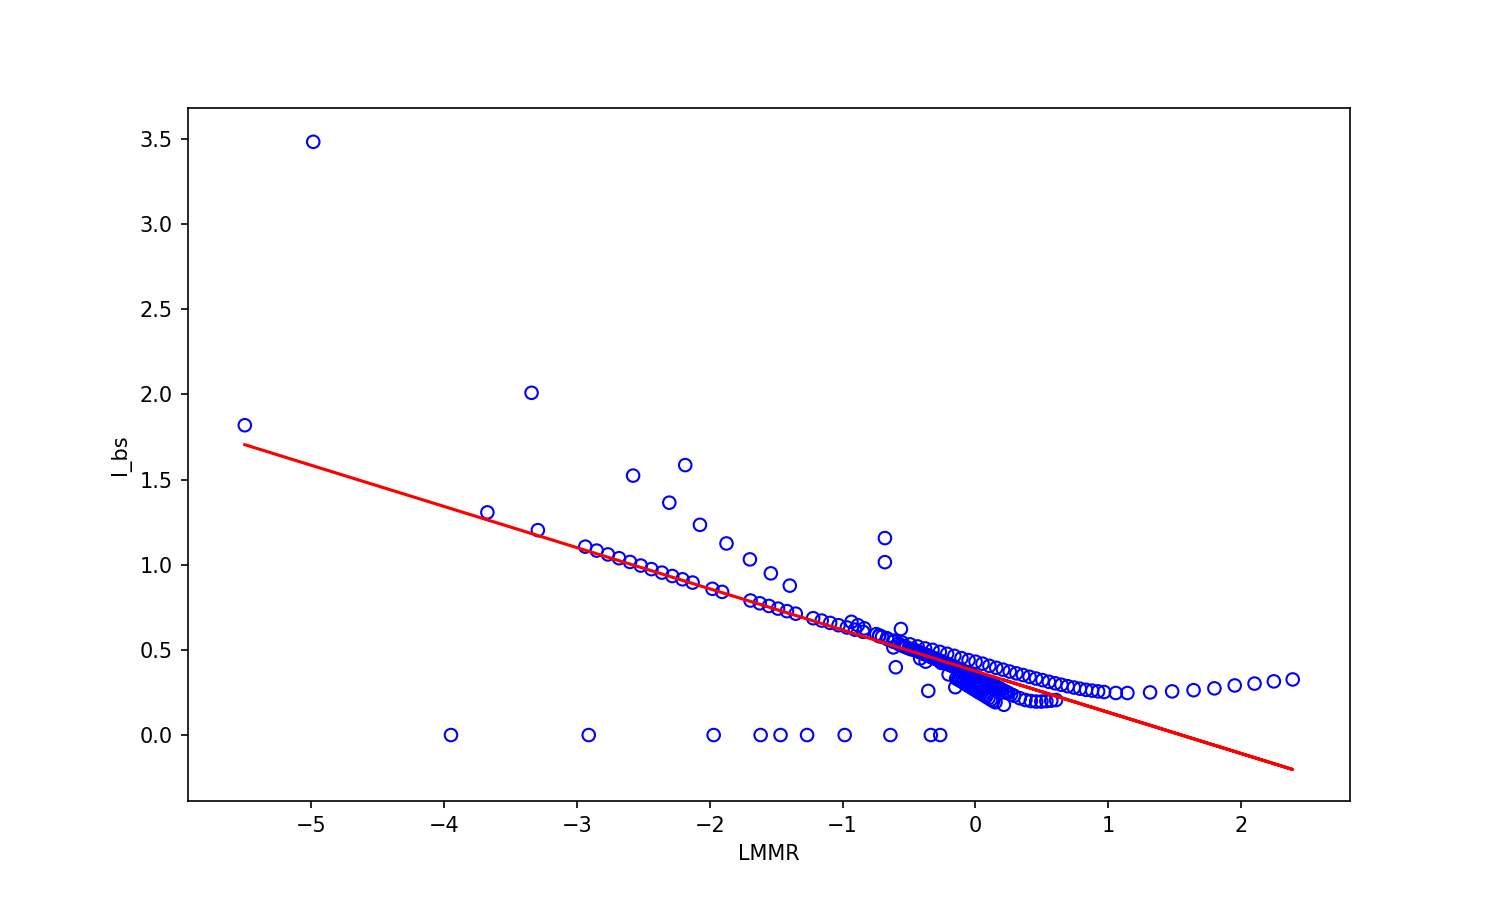

Text(0, 0.5, 'I_bs')

In [49]:
reg = LinearRegression().fit(df[["LMMR"]], df["I_bs"])

plt.figure(figsize= (10, 6))
plt.plot(df["LMMR"], reg.predict(np.array(df["LMMR"]).reshape(-1,1)), c = "r")
plt.scatter(df["LMMR"], df["I_bs"], marker = "o", facecolors='none', edgecolors = "b")
plt.xlabel("LMMR")
plt.ylabel("I_bs")

<IPython.core.display.Javascript object>


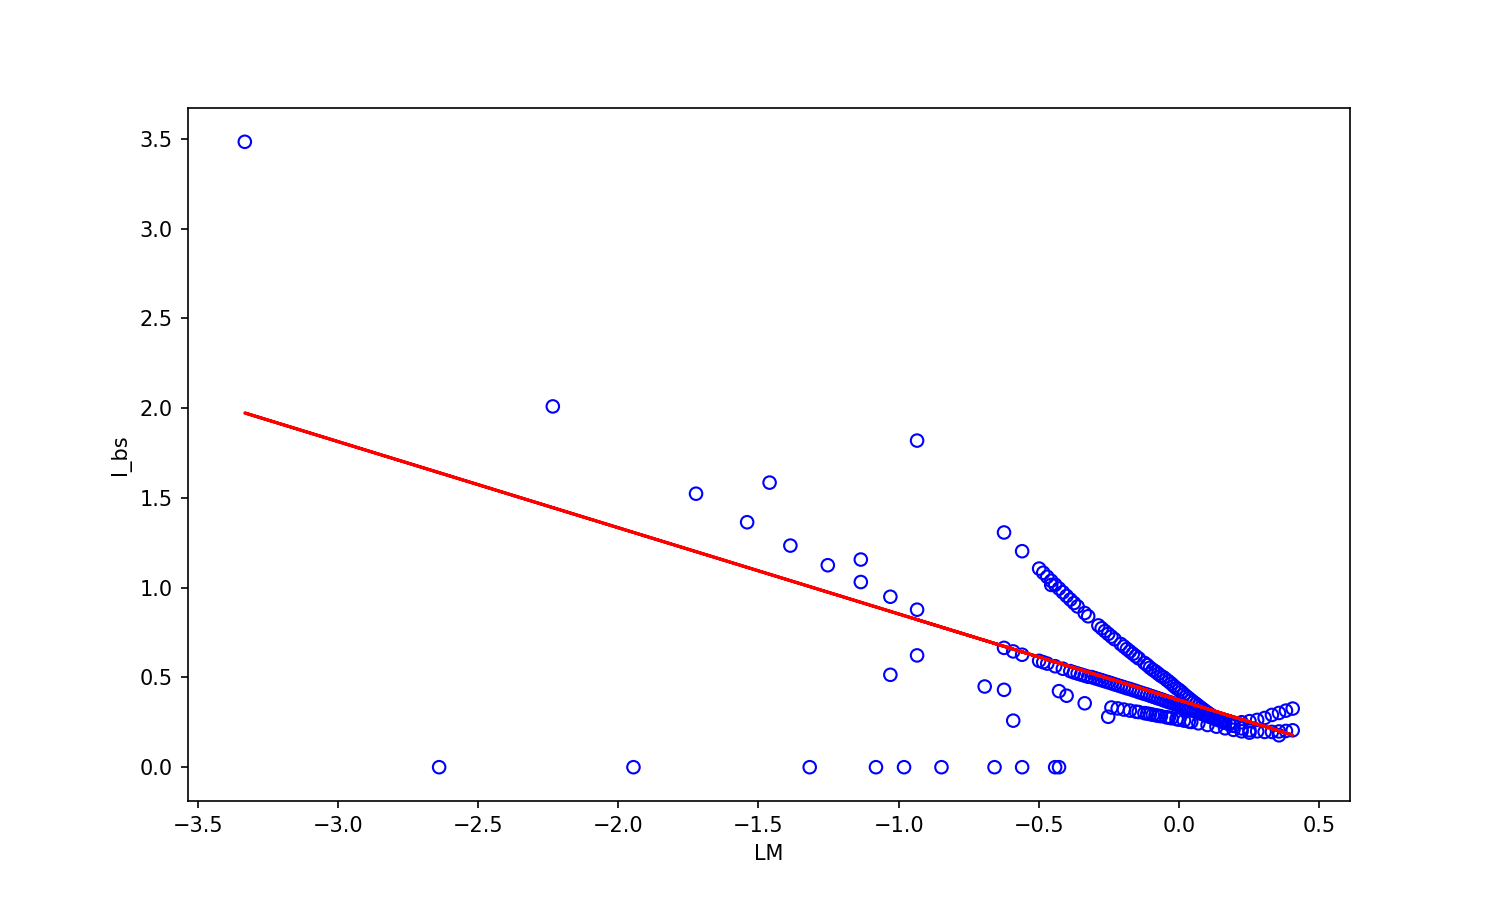

Text(0, 0.5, 'I_bs')

In [50]:
reg = LinearRegression().fit(df[["LM"]], df["I_bs"])

plt.figure(figsize= (10, 6))#figsize= (10, 6))
plt.plot(df["LM"], reg.predict(np.array(df["LM"]).reshape(-1,1)), c = "r")
plt.scatter(df["LM"], df["I_bs"], marker = "o", facecolors='none', edgecolors = "b")
plt.xlabel("LM")
plt.ylabel("I_bs")

## 3.3 - Calcul des grecques

In [51]:
df["d1"] = (-df["LM"] + (r + msigma ** 2 / 2) * df["tau"]) / (msigma * np.sqrt(df["tau"]))

df["Delta"] = norm.cdf(df["d1"])
df["Vega"] = df["S0"] * norm.pdf(df["d1"]) * np.sqrt(df["tau"])
df["Vanna"] = df["Vega"] / df["S0"] * (1 - df["d1"]/ (msigma * np.sqrt(df["tau"])))

<IPython.core.display.Javascript object>


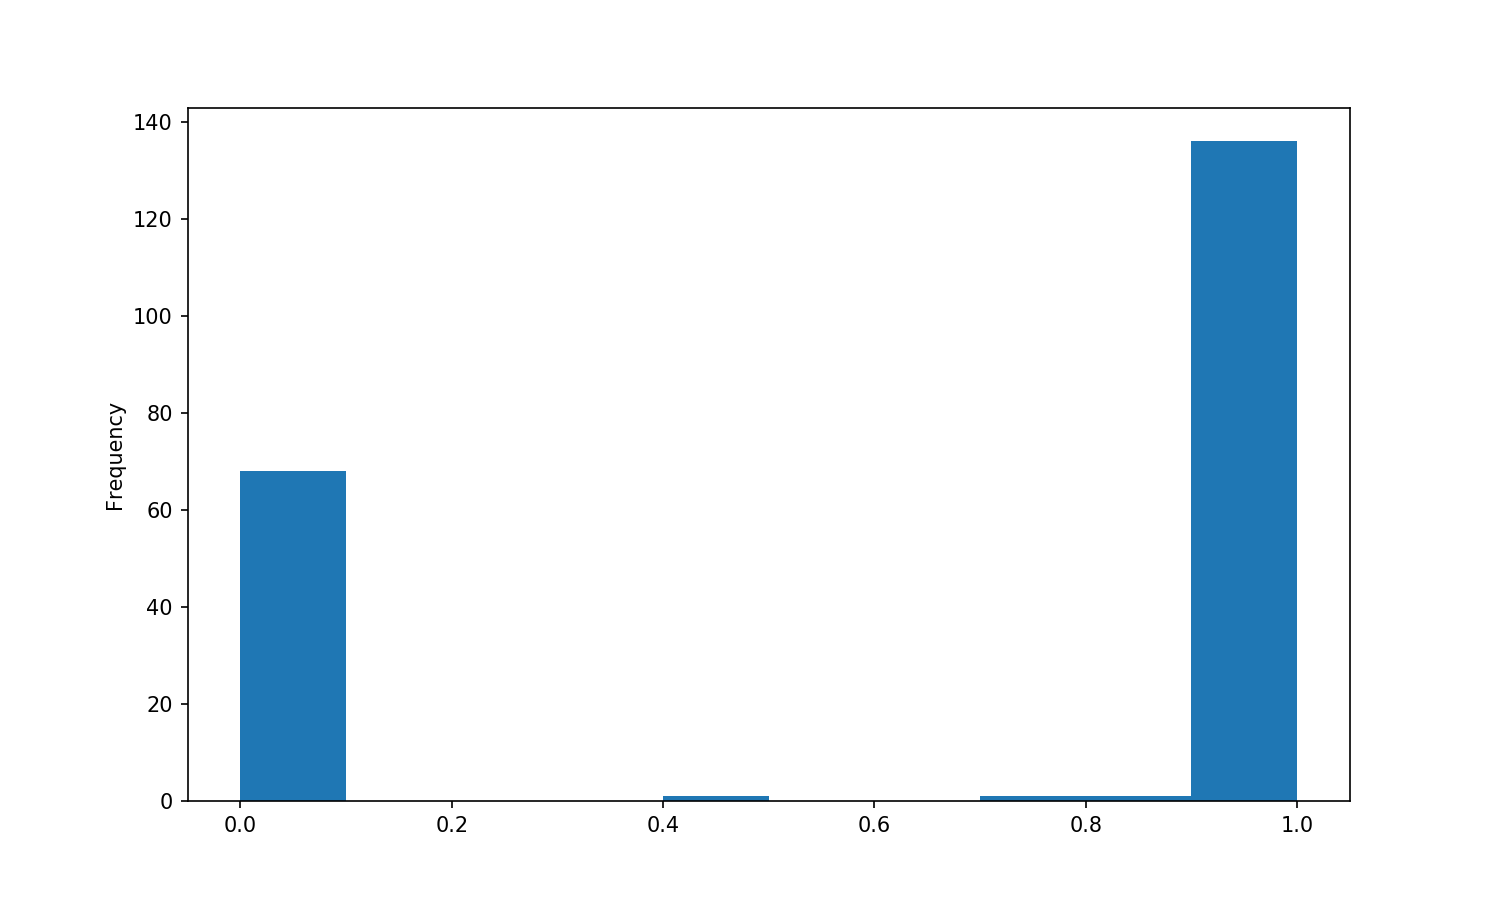

In [52]:
# Répartition de delta
plt.figure()
df["Delta"].plot.hist(figsize=(10, 6))

<IPython.core.display.Javascript object>


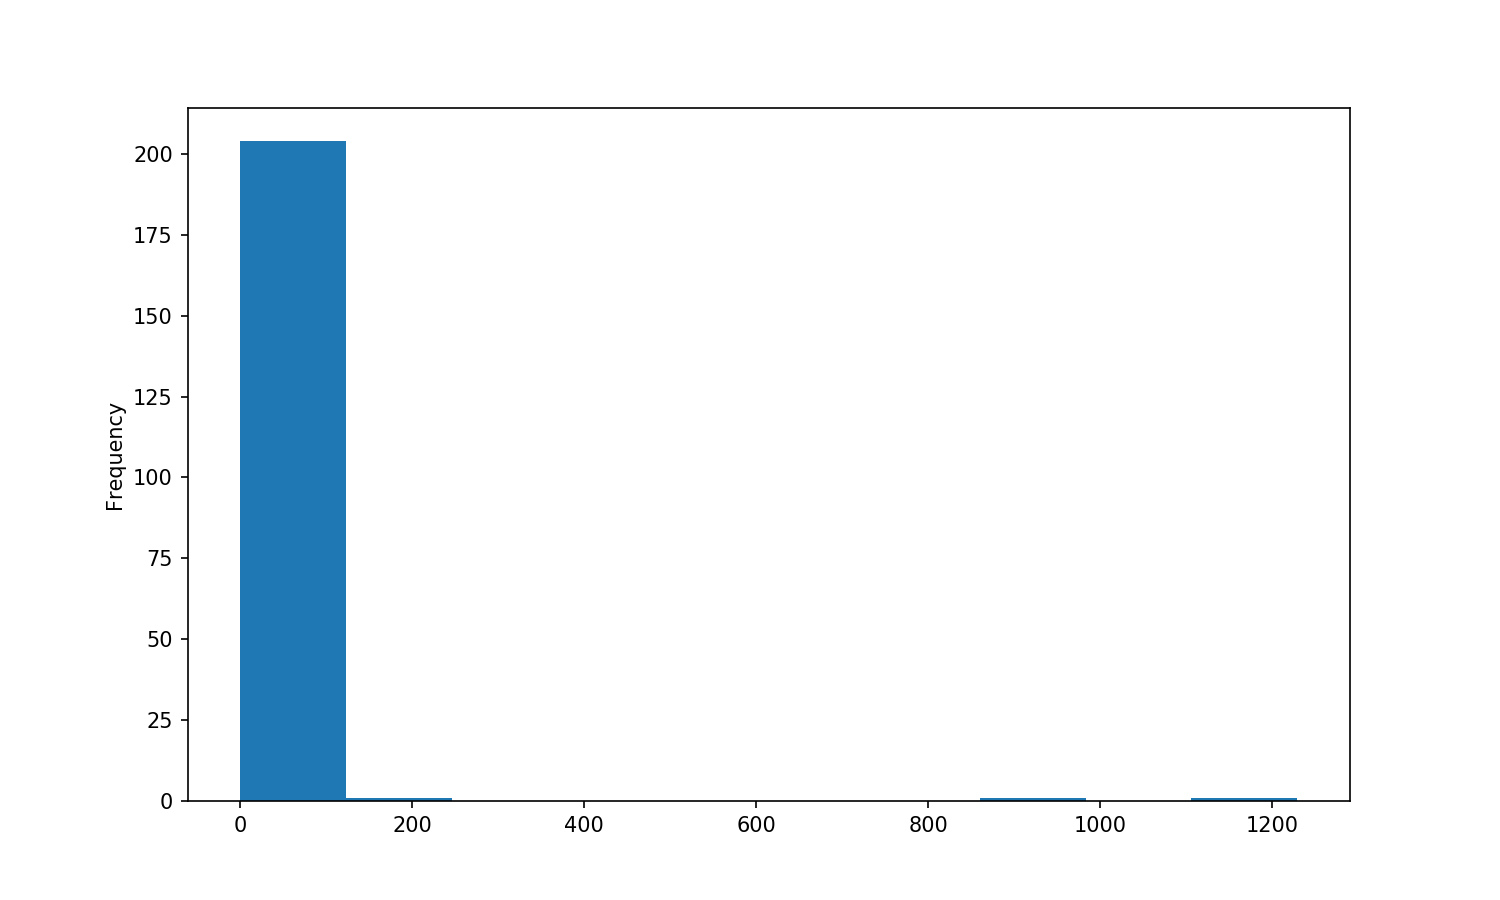

In [53]:
# Répartition de Vega
plt.figure()
df["Vega"].plot.hist(figsize=(10, 6))

Enfin, on calcule le prix de notre option dans le modèle grâce à la formule : 
\begin{equation*}
        \tilde P^{\epsilon, \delta} = P_{BS} - \dfrac{1}{\bar{\sigma}} \left[ (V_2^\varepsilon + \tau V_0^\delta)\mathcal{V} + (V_3^\varepsilon + \tau  V_1^\delta )\Delta_\mathcal{V} \right]
    \end{equation*}

## 3.4 - Calcul des prix

In [54]:
df["P_bs"] = df["S0"] * norm.cdf(df["d1"]) - df["K"] * np.exp(- r * df["tau"]) * norm.cdf(df["d1"] - msigma * np.sqrt(df["tau"]))
df["P_tilde_eps_delta"] = df["P_bs"] - ((V_2_eps + df["tau"] * V_0_delta) * df["Vega"] + (V_3_eps + df["tau"] * V_1_delta) * df["Vanna"]) / msigma

<IPython.core.display.Javascript object>


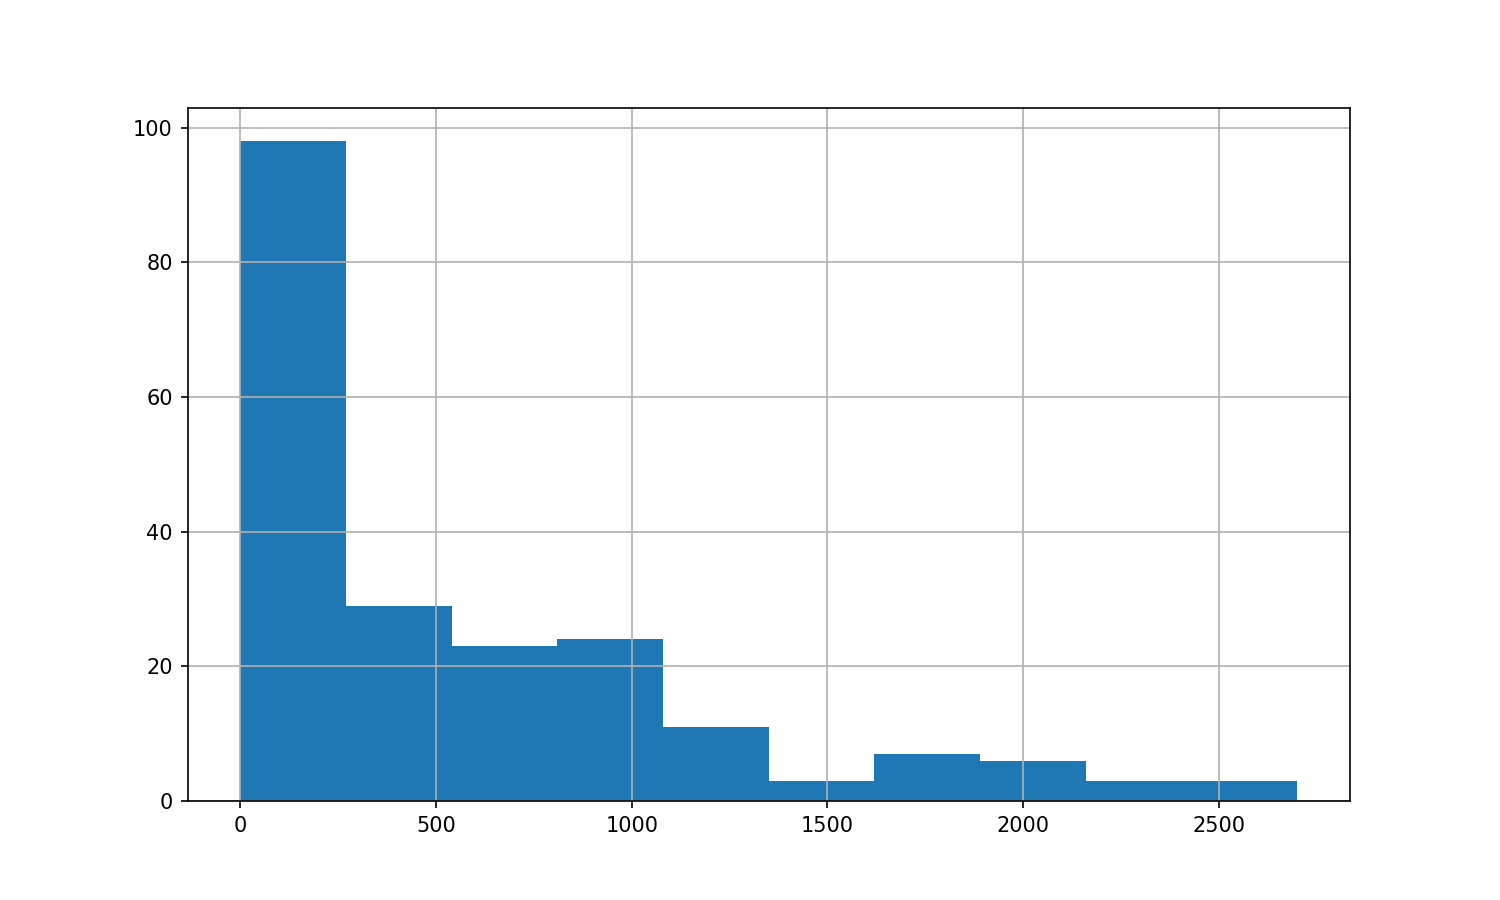

In [55]:
# Répartition des prix de black scholes
plt.figure()
df["P_bs"].hist(figsize= (10, 6))

<IPython.core.display.Javascript object>


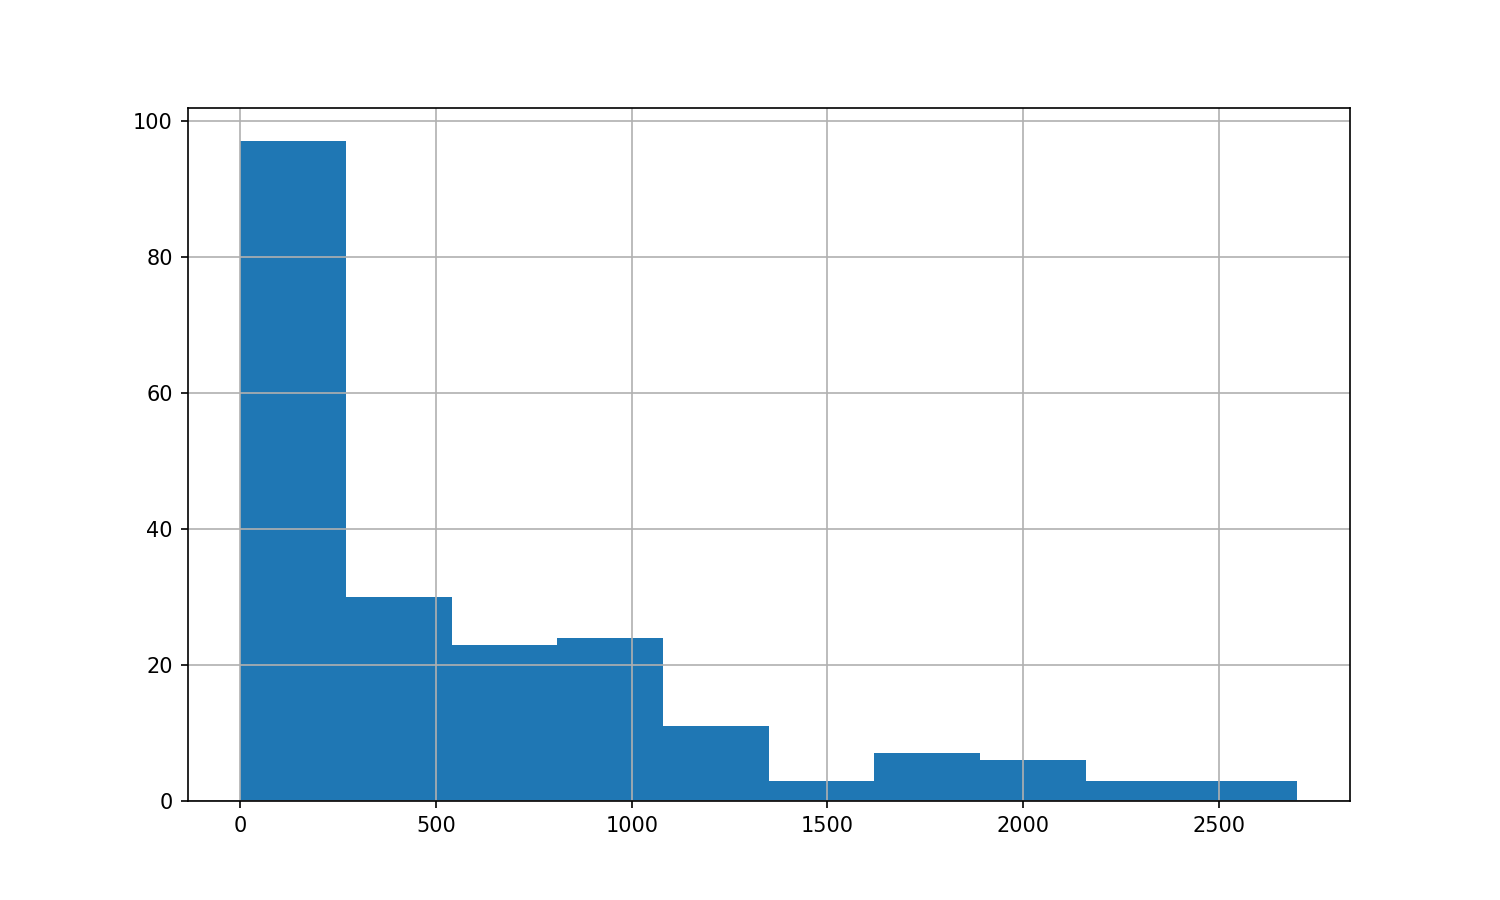

In [56]:
# Répartition des nouveaux prix
plt.figure()
df["P_tilde_eps_delta"].hist(figsize =  (10, 6))